<a href="https://colab.research.google.com/github/waveology/kitchen/blob/main/02_introduccion_cdo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<html><img src="https://owncloud.aemet.es/index.php/s/lwiFbCGBRAJHlF7/download?path=%2F&files=logo.png"></html>


* **Autor:** Ernesto Barrera
* **Institución:** AEMET
---

# Introducción a **cdo** (Climate Data Operators)


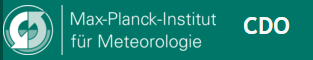

* [Web del proyecto](https://code.mpimet.mpg.de/projects/cdo/wiki/Cdo#Documentation)
* [Guía de usuario](https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf)

* **¿Qué es CDO?** Un conjunto (extenso) de operadores que actúan sobre ficheros en formato NetCDF o GRIB.

* **¿Cómo se usa CDO?** Se invocan en línea de comandos aunque existe un interfaz Python.

* **¿Cuándo usar CDO?** Cuando se requiera el
preproceso eficiente en memoria, especialmente con datos masivos.

* **¿Por qué CDO?** Porque funciona tanto con datos GRIB como con NetCDF





* **Uso simple**:

> cdo operador fichero_entrada fichero_salida

* **Uso encadenado**:

> cdo -operador1 fichero_entrada1 -operador2 fichero_entrada2 [...] fichero_salida

* **Paralelización OMP**:

> cdo -P 12 -operador_paralelizado fichero_entrada fichero_salida


**Organización de los operadores por tipo de acción:**
>* Información
* Operaciones con ficheros
* Selección
* Comparación
* Modificación
* Aritmética
* Estadística
* Correlación
* Regresión
* Componentes principales
* Interpolación
* Transformación
* Entradas y salidas
* Miscelánea


## Instalación desde condacolab
---

In [ ]:
# Instala conda en Colab
# Este proceso implica un reinicio del kernel y
# es normal que aparezca un mensaje de fallo en la sesión
# --------------------------------------------------------
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Verifica la instalación
# ------------------------
import condacolab
condacolab.check()


In [ ]:
# Instala cdo
# ----------------------
!mamba install -q cdo

##Descarga de datos
---

Descargamos ficheros de datos del reanálisis ERA/ECMWF para experimentar

In [ ]:
ifile = 'era5_t2m_w10_2020_europa_025.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/7tJ8c3UpRK9sqVE/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_t2m_w10_2020_europa_025.nc era5_2000.nc

ifile = 'era5_t2m_1987_2020_europa_025_lsm.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/leirUBqlMnLxIAL/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_t2m_1987_2020_europa_025_lsm.nc mascara_tierra_mar.nc

## Operadores de [información](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-560002.1)
---

Permiten obtener metadatos de los ficheros (variables, coordenadas, tiempos, etc)

In [ ]:
# Información y estadística básica
# ---------------------------------
!cdo info era5_2000.nc | head -n 10

In [ ]:
# Información reducida
# ---------------------------------
!cdo sinfo era5_2000.nc | head -n 20

In [ ]:
# Nombre de las variables
# -----------------------
!cdo showname era5_2000.nc

In [ ]:
# Número de parámetros
# ---------------------------------
!cdo npar era5_2000.nc

In [ ]:
# Número de niveles
# ---------------------------------
!cdo nlevel era5_2000.nc

In [ ]:
# Número de fechas
# ---------------------------------
!cdo ndate era5_2000.nc

In [ ]:
# Número de puntos de rejilla de cada variable
# --------------------------------------------
!cdo ngridpoints era5_2000.nc

In [ ]:
# Formato del fichero
# --------------------
!cdo showformat era5_2000.nc

In [ ]:
# Atributos NetCDF de las variables
# ----------------.........----------
!cdo showatts era5_2000.nc

## [Operadores de ficheros](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-920002.2)
---

###Separación
Entre los más usados están aquellos que permiten trocear o fusionar los ficheros en base a algun criterio (variables, tiempo, etc).

Los operadores con prefijo 'split' se usan para separar:

In [ ]:
# Separa un fichero de datos anuales en 12 ficheros
# con datos mensuales
# ---------------------------------------------------
!cdo splitmon era5_2000.nc mes_

In [ ]:
# Muestra las fechas contenidas en el fichero correspondiente
# al mes de febrero
# ------------------------------------------------------------
!cdo showdate mes_02.nc

In [ ]:
# Separa el fichero de datos de febrero en uno por cada variable
# ---------------------------------------------------------------
!cdo splitvar mes_02.nc febrero_

###Fusion
La operación inversa de aglutinar información de múltiples ficheros en uno se lleva a cabo con los operadores de prefijo *merge*

In [ ]:
# Separa el fichero de datos de febrero en uno por cada variable
# ---------------------------------------------------------------
!cdo mergetime mes_12.nc mes_01.nc mes_02.nc DJF.nc

In [ ]:
# Muestra las fechas contenidas en el fichero correspondiente
# al mes de febrero
# ------------------------------------------------------------
!cdo showdate DJF.nc

En muchos casos, los operadores pueden encadenarse anteponiendo un guión a su nombre. Esto optimiza los procesos porque evitan la creación de ficheros intermedios y la escritura a disco es a menudo un cuello de botella en el cálculo intensivo.

In [ ]:
# Encadenado de operadores
# 1) se fusionan los datos correspondientes a los meses de verano
# 2) la fusión resultante se separa en un fichero por cada variable
# ----------------------------------------------------------------------
!cdo  -splitvar -mergetime mes_06.nc mes_07.nc mes_08.nc JJA_

In [ ]:
# Limpieza
# ----------------------------------
!rm -f mes_*.nc febrero_*.nc JJA_*.nc

##Operadores de [selección](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-1670002.3)
---

Permiten elegir el contenido de un fichero en base a diversos criterios

###Ejemplo: selección de datos estacionales

In [ ]:
# Selecciona los datos correspondientes a la temperatura del invierno climatológico
# ----------------------------------------------------------------------------------
!cdo select,name=t2m,season=DJF era5_2000.nc DJF_t2m.nc

In [ ]:
# Elimina los días 29 de febrero que encuentre en
# el fichero de entrada (dom = day of month)
# -------------------------------------------------------
!cdo delete,dom=29feb DJF_t2m.nc DJF_t2m_sin_29feb.nc

In [ ]:
# Comprobación
# ------------------------------------------------------------
!cdo showdate DJF_t2m.nc
!cdo showdate DJF_t2m_sin_29feb.nc

###Ejemplo: operadores encadenados

Las mismas operaciones pero encadenando los operadores.

* Nótese que en general, el orden de encadenamiento puede afectar a la eficiencia.
* Cuando existe ambigüedad en el ámbito de actuación de los operadores se usan paréntesis para clarificarla.

In [ ]:
# Selecciona los datos correspondientes al invierno climatológico y eliminamos el 29 de febrero del resultado
# -O fuerza la sobreescritura de un fichero preexistente
# El resultado de 'select' solo existe en memoria
# ---------------------------------------------------------------------------------------------------------
!cdo -O  -delete,dom=29feb [ -select,name=t2m,season=DJF   era5_2000.nc ]  DJF_t2m_sin_29feb.nc

In [ ]:
# Selecciona un rango arbitrario de fechas
# -------------------------------------------
!cdo seldate,'2020-07-24T00:00:00','2020-08-15T23:59:59' era5_2000.nc europa.nc

## Se obtiene el mismo resultado usando el operador genérico 'select'
## -------------------------------------------------------------------
# !cdo -O select,startdate='2020-07-24T00:00:00',enddate='2020-08-15T23:59:59' era5_2000.nc europa.nc

###Ejemplo: selección de una ventana geográfica

In [ ]:
!cdo sinfo europa.nc | head -n 10

In [ ]:
# Selecciona una ventana geográfica en torno a la península ibérica
# ------------------------------------------------------------------
!cdo sellonlatbox,-12,5,35,45 europa.nc  peninsula.nc

In [ ]:
# Importamos xarray y Matplotlib para inspeccionar gráficamente el contenido de los ficheros
# -------------------------------------------------------------------------------------------
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
# Dibujamos el fichero original y el resultante de la selección de ventana geográfica
# ------------------------------------------------------------------------------------
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
t1 = xr.open_dataset('europa.nc').t2m.sel(time='20200731').plot(ax=ax1)
t2 = xr.open_dataset('peninsula.nc').t2m.sel(time='20200731').plot(ax=ax2)

###Ejemplo: remuestreo (sin interpolación)

In [ ]:
# Remuestreo (no requiere interpolación)
# --------------------------------------------
!cdo samplegrid,4 peninsula.nc remuestreo_4.nc

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
xr.open_dataset('peninsula.nc').t2m.sel(time='20200731').plot(ax=ax1)
xr.open_dataset('remuestreo_4.nc').t2m.sel(time='20200731').plot(ax=ax2)

In [ ]:
# Limpieza
# ---------
!rm -f europa_*.nc peninsula_*.nc

##Operadores de [selección condicional](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2180002.4)
---

Permiten extraer datos de un campo en base a una máscara. Los valores de la máscara pueden ser 0 (falso) o superiores a cero (verdadero).

###Ejemplo: uso de una máscara tierra-mar

In [ ]:
# Esta máscara tiene valor 1 en tierra y valor 0 en el mar
# --------------------------------------------------------
!cdo showatts mascara_tierra_mar.nc

In [ ]:
# Extraemos la temperatura de un día cualquiera
# ----------------------------------------------
!cdo select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc t.nc

In [ ]:
# Aplicamos la máscara para seleccionar solo los valores de temperatura en tierra
# --------------------------------------------------------------------------------
!cdo ifthen   mascara_tierra_mar.nc   t.nc   temperatura_tierra.nc

In [ ]:
!cdo showvar temperatura_tierra.nc

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t.nc').t2m.isel(time=0).plot(ax=ax1)
xr.open_dataset('mascara_tierra_mar.nc').lsm.isel(time=0).plot(ax=ax2)
xr.open_dataset('temperatura_tierra.nc').t2m.isel(time=0).plot(ax=ax3)

In [ ]:
# Para seleccionar la temperatura en el mar
# Ahora encadenamos los operadores
#------------------------------------------
!cdo -ifnotthen  mascara_tierra_mar.nc -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc  temperatura_mar.nc

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t.nc').t2m.isel(time=0).plot(ax=ax1)
xr.open_dataset('mascara_tierra_mar.nc').lsm.isel(time=0).plot(ax=ax2)
xr.open_dataset('temperatura_mar.nc').t2m.isel(time=0).plot(ax=ax3)

también es posible asignar un valor constante al área enmascarada

In [ ]:
# Selección de la temperatura del mar en invierno y la de tierra en verano
#------------------------------------------------------------------------------
!cdo -select,name='t2m',date='2020-06-22T12:00:00' era5_2000.nc t_verano.nc
!cdo -select,name='t2m',date='2020-12-22T12:00:00' era5_2000.nc t_invierno.nc
!cdo -ifthenelse  mascara_tierra_mar.nc t_verano.nc t_invierno.nc hibrido.nc

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t_verano.nc').t2m.isel(time=0).plot(ax=ax1,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('t_invierno.nc').t2m.isel(time=0).plot(ax=ax2,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('hibrido.nc').t2m.isel(time=0).plot(ax=ax3,cmap='rainbow',vmin=280,vmax=320)

## Operadores de [comparación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2390002.5)
---

Realizan comparaciones numéricas entre campos y guardan el resultado (ceros y unos) en un nuevo fichero que puede ser usado como máscara en otras operaciones.

###Ejemplo: creación de una máscara

In [ ]:
# Selección de datos de temperatura del 1 de julio de 2020
# -----------------------------------------------------------
!cdo -select,name='t2m',date='2020-07-01T12:00:00'  era5_2000.nc julio.nc
# Selección de datos de temperatura del 1 de agosto de 2020
# -----------------------------------------------------------
!cdo -select,name='t2m',date='2020-08-01T12:00:00'  era5_2000.nc agosto.nc

# Creación de una máscara que toma valor 1 si la temperatura en julio supera la de agosto
# La opción -b F32 se asegura de que la comparación se realiza con la precisión necesaria
# ----------------------------------------------------------------------------------------
!cdo -b F32 -gt   julio.nc   agosto.nc   julio_mayor_que_agosto.nc

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('julio.nc').t2m.isel(time=0).plot(ax=ax1,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('agosto.nc').t2m.isel(time=0).plot(ax=ax2,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('julio_mayor_que_agosto.nc').t2m.isel(time=0).plot(ax=ax3,cmap='rainbow',vmin=0,vmax=1)

##Operadores de [modificación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2510002.6)
---

Realizan cambios en los datos o en los metadatos. Las posibilidades son muy diversas.

###Ejemplo: cambio o adición de atributos NetCDF

In [ ]:
# Atributos antes
# ---------------------
!cdo showatts agosto.nc

# Añadimos un atributo local a la variable t2m
# ----------------------------------------------
!cdo setattribute,t2m@nuevo_atributo="propiedad interesante" agosto.nc tmp

# Añadimos un atributo global
# ----------------------------------------------
!cdo setattribute,fiabilidad="Alta" tmp agosto_mod.nc

# Borra el fichero intermedio
# ----------------------------
!rm -f tmp

# Atributos después
# -------------------
!cdo showatts agosto_mod.nc

In [ ]:
# Versión que encadena la adición de los dos atributos
# ----------------------------------------------------
!cdo -O -setattribute,t2m@nuevo_atributo="propiedad interesante" -setattribute,fiabilidad="Alta" agosto.nc agosto_modificado.nc

###Ejemplo: invertir el orden de las latitudes

In [ ]:
# Invierte el sentido del eje de latitudes
# ----------------------------------------
!cdo sinfo julio.nc
!cdo invertlat julio.nc julio_invlat.nc
!cdo sinfo julio_invlat.nc

In [ ]:
# Para algunas aplicaciones es preferible tener un eje de latitudes crecientes
# Por ejemplo, esta extracción de un rango de latitudes en xarray da un error
# porque en el fichero las latitudes están dispuestas de mayor a menor
# --------------------------------------------------------------------------------
# xr.open_dataset('julio.nc').t2m.isel(time=0).sel(latitude=slice(25,55)).plot()

# Con el fichero modificado funciona sin problemas
# --------------------------------------------------
xr.open_dataset('julio_invlat.nc').t2m.isel(time=0).sel(latitude=slice(25,55)).plot(size=4)

###Invalidación de datos mediante un área 'rectangular'

Para especificar una ventana delimitada por paralelos y meridianos basta con indicar las latitudes y longitudes de los contornos con el operador *masklonlatbox*

Los valores exteriores al área definida se etiquetan como no válidos

In [ ]:
# Enmascaramos los datos en el exterior de la región
# Los valores se etiquetan como no válidos (missing)
# ---------------------------------------------------
!cdo -O masklonlatbox,-25,5,30,50 agosto.nc region.nc

# Datos de temperatura en el interior de la región
# --------------------------------------------------
xr.open_dataset('region.nc').t2m.isel(time=0).plot(size=4)

###Ejemplo: retención de datos mediante un área arbitraria

In [ ]:
# Definimos una región indicando las coordenadas de los vértices
# ---------------------------------------------------------------
!rm -f             region.txt
!echo "-5 30"   >> region.txt
!echo "-15 40"  >> region.txt
!echo "-5 50"   >> region.txt
!echo "5 40"    >> region.txt

In [ ]:
# Enmascaramos los datos en el exterior de la región
# Los valores se etiquetan como no válidos (missing)
# ---------------------------------------------------
!cdo maskregion,region.txt agosto.nc region.nc

In [ ]:
# Datos de temperatura en el interior de la región
# --------------------------------------------------
xr.open_dataset('region.nc').t2m.isel(time=0).plot(size=4)

###Ejemplo: invalidación de datos por valor

A veces es necesario invalidar determinados datos para que no sean tenidos en cuenta en el cómputo

In [ ]:
# Invalidamos los datos de temperatura en el rango 293-298 K (20-25ºC)
# ----------------------------------------------------------------------
!cdo setrtomiss,293,298 julio.nc  julio_sin_293-298K.nc

# Muestra el mapa sin los valores anulados
# --------------------------------------------------------------------
xr.open_dataset('julio_sin_293-298K.nc').t2m.isel(time=0).plot(size=4)

##Operadores de [aritmética](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-3370002.7)
---

Resultan extremadamente útiles los operadores que permiten calcular nuevos campos actuando sobre los existentes.

* **expr**:  evalúa expresiones aritméticas que se guardan en un nuevo fichero
* **aexpr**:  evalúa expresiones aritméticas que se anexan al fichero original


Cuando las expresiones son complicadas o involucran a varios campos puede ser más conveniente que definirlas en un script independiente. En ese caso, los operadores a utilizar son:

* **exprf**  
* **aexprf**

###Ejemplo: nuevo campo de velocidad de viento a partir de componentes vectoriales

In [ ]:
!cdo seldate,'2020-12-24T12:00:00' era5_2000.nc xmas.nc
!cdo showvar xmas.nc

En este ejemplo el fichero de salida solo contiene el campo creado

In [ ]:
# Calcula el módulo del vector de viento
# ---------------------------------------------
!cdo expr,viento='sqrt(u10*u10+v10*v10)' xmas.nc xmas_viento.nc

# Tenemos una única variable llamada 'viento'
# --------------------------------------------
!cdo showvar xmas_viento.nc

En la versión que usa aexpr en lugar de expr el fichero de salida contiene tanto las variables antiguas como las nuevas

In [ ]:
# Crea una nueva variable con el módulo del viento
# Crea una nueva variable con la temperatura en ºC
# -------------------------------------------------
!cdo -O aexpr,viento='sqrt(u10*u10+v10*v10);tc=t2m-273.15;' xmas.nc xmas_viento.nc

# Tenemos todas las variables en el nuevo fichero
# --------------------------------------------
!cdo showvar xmas_viento.nc

In [ ]:
# Dibujamos el campo de velocidad del viento (módulo del vector) recién creado
# -----------------------------------------------------------------------------
xr.open_dataset('xmas_viento.nc').viento.isel(time=0).plot(size=5, cmap='jet')


# # ¿Añadimos los vectores al gráfico?
# # --------------------------------------
# xr.open_dataset('xmas.nc').isel(time=0).thin({'longitude':5,'latitude':5}).plot.quiver(x='longitude',y='latitude',u='u10',v='v10')


###Ejemplo: conversión de temperaturas de Kelvin a grados centígrados

Es posible aplicar operaciones aritméticas sobre los ficheros involucrando constantes. Por ejemplo, el cambio de unidades de la temperatura se puede llevar a cabo de esta otra manera:



In [ ]:
!cdo -b F32 -addc,-273.15 -selvar,t2m xmas.nc tc_xmas.nc

xr.open_dataset('tc_xmas.nc').t2m.isel(time=0).plot(size=5, cmap='jet')

###Ejemplo: diferencia de campos

También se pueden realizar determinadas operaciones en pares de ficheros

In [ ]:
!cdo -b F32 sub agosto.nc julio.nc diferencia_julio_agosto.nc

xr.open_dataset('tc_xmas.nc').t2m.isel(time=0).plot(size=5, cmap='seismic')

###Ejemplo: cálculo de anomalías encadenando operadores

In [ ]:
# Extrae solamente los campos de temperatura y pasa de Kelvin a ºC
# --------------------------------------------------------------------
!cdo -b F32  -addc,-273.15 -selvar,t2m  era5_2000.nc   tc.nc

# En cada punto de rejilla sustraemos el promedio mensual de temperatura
# --------------------------------------------------------------------
!cdo -b F32  -monsub tc.nc -monavg  tc.nc  tc_sin_variacion_estacional.nc


In [ ]:
# Dibujamos la serie temporal de anomalías correspondiente a Madrid
# ------------------------------------------------------------------
fig,(ax1,ax2)=plt.subplots(2,1)
xr.open_dataset('tc.nc').t2m.sel(longitude=-3,latitude=40, method='nearest').plot(ax=ax1)
xr.open_dataset('tc_sin_variacion_estacional.nc').t2m.sel(longitude=-3,latitude=40, method='nearest').plot(ax=ax2)
plt.tight_layout()

###Ejemplo: añadir nuevos campos con sus atributos

In [ ]:
# Escribimos las instrucciones en un fichero terminadas con punto y coma
# -----------------------------------------------------------------------
! rm -f operaciones.txt
! echo 'viento=sqrt(u10*u10+v10*v10);' >  operaciones.txt
! echo 'tc=t2m-273.15;'                >> operaciones.txt

# Realizamos las operaciones y guardamos los resultados en
# un fichero independiente. Si quisiéramos anexar las nuevas
# variables en el fichero original usaríamos el operador 'aexprf'
# ----------------------------------------------------------------
!cdo -O -setattribute,tc@info='Temperatura 2m',tc@unidades='°C',viento@info='viento a 10m',viento@unidades='m/s' -exprf,operaciones.txt xmas.nc xmas_viento.nc

In [ ]:
# Comprobamos el resultado
# ------------------------------
!cdo showatts xmas_viento.nc

#Operadores [estadísticos](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-4040002.8)
---

Hay más de 250 operadores estadísticos en CDO.

Dos cosas importantes a tener en cuenta:

* cdo distingue entre los conceptos de 'mean' y 'average'. El primero descarta los valores no válidos (*missing*) mientras que el segundo no:

>>mean(1,2,3, missing) = 2

>>average(1,2,3, missing) = missing

>>Si no hay valores 'missing' ambas operaciones dan el mismo resultado.

* Cuando se calculan valores medios en rejillas latitud-longitud, el resultado se pondera por defecto con el área de los elementos de superficie.

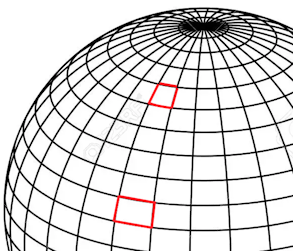


###Ejemplo: Resultados de promedios calculados con **mean** y **average**

In [ ]:
# Extraemos la temperatura del día 2 de febrero de 2020
# Etiquetamos los valores comprendidos entre 273 y 300 K como inválidos (missing)
# Calculamos el valor medio con 'mean' en el dominio geográfico teniendo en cuenta las áreas de cada elemento
# Exportamos el resultado en formato tabular
# ---------------------------------------------------------------------------------------------------
!cdo -s -outputtab,date,lon,lat,value [ -fldmean   -setrtomiss,273,300  -select,name=t2m,date=2020-02-06T12:00:00 era5_2000.nc ]


# Lo mismo pero calculando el valor medio con 'average'
# -----------------------------------------------------
!cdo -s -outputtab,date,lon,lat,value [ -fldavg    -setrtomiss,273,300  -select,name=t2m,date=2020-02-06T12:00:00 era5_2000.nc ]

# Ejemplo: medias zonales (en longitud) y meridionales (en latitud)

In [ ]:
# Extraemos la temperatura del día 10 de enero de 2020
# ----------------------------------------------------
!cdo -select,name=t2m,date=2020-01-10T12:00:00 era5_2000.nc t.nc

# Calculamos la media zonal
# ------------------------------------
!cdo -zonmean t.nc media_zonal.nc

# Calculamos la media meridional
# ------------------------------------
!cdo -mermean t.nc media_meridional.nc

In [ ]:
# Representamos gráficamente los resultados
# -------------------------------------------
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
xr.open_dataset('t.nc').t2m.plot(ax=ax1, cmap='jet')
xr.open_dataset('media_zonal.nc').t2m.plot(ax=ax2)
xr.open_dataset('media_meridional.nc').t2m.plot(ax=ax3)
ax2.set_title('Media zonal de temperatura a 2m')
ax3.set_title('Media meridional de temperatura a 2m')
plt.tight_layout()

#Operadores de [interpolación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-6650002.12)

* Existen múltiples opciones de interpolación que benefician de la ejecución paralela.

* Los procesos de pueden optimizar guardando un fichero de pesos de interpolación

###Ejemplo: interpolaciones bilineales y bicúbicas

El fichero de temperaturas t.nc tiene una resolución espacial de 0.25º y un área limitada por los paralelos 20N y 60N y los meridianos 30W y 10E.

Para obtener una interpolación bilineal con resolución de 0.05º solo necesitamos consignar en un fichero de texto los siguientes datos:

la coordenada de partida,

* xfirst = -30
* yfirst =  10

la resolución deseada,

* xinc  = 0.05
* yinc  = 0.05

y el número de puntos de rejilla resultante en la nueva resolución,

* xsize = |lon1 - lon2| / resolución + 1 = 801
* ysize = |lat1 - lat2| / resolución + 1 = 801

Si estuviéramos interesados en un recorte xsize e ysize deberían ajustarse como corresponda.


In [ ]:
!echo "gridtype  = lonlat"  >  gridfile
!echo "xsize     = 801"     >> gridfile
!echo "ysize     = 801"     >> gridfile
!echo "xfirst    = -30.0"   >> gridfile
!echo "xinc      =  0.05"    >> gridfile
!echo "yfirst    = 60.0"    >> gridfile
!echo "yinc      = -0.05"    >> gridfile

# Interpolación bilineal
# -----------------------
!cdo remapbic,gridfile t.nc t_005.nc


# # Interpolación bicúbica
# # -----------------------
# !cdo remapbic,gridfile t.nc t_005.nc

In [ ]:
!echo "gridtype  = lonlat"  >  gridfile
!echo "xsize     = 4001"     >> gridfile
!echo "ysize     = 4001"     >> gridfile
!echo "xfirst    = -30.0"   >> gridfile
!echo "xinc      =  0.01"    >> gridfile
!echo "yfirst    = 60.0"    >> gridfile
!echo "yinc      = -0.01"    >> gridfile

# Interpolación bicúbica
# -----------------------
!time cdo remapbic,gridfile t.nc t_001.nc


# Interpolación bicúbica con paralelización
# -----------------------------------------
!time cdo -P 2 remapbic,gridfile t.nc t_001.nc

In [ ]:
# Representamos gráficamente haciendo un zoom
# en una ventana para apreciar mejor los detalles
# ------------------------------------------------
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ds = xr.open_dataset('t.nc').t2m.isel(time=0).sel(longitude=slice(-7.5,2.5),latitude=slice(44,40))
ds.plot(ax=ax1, cmap='jet')
c=ds.plot.contour(ax=ax1,levels=range(270,320,2),colors='black',add_labels=True)
ax1.clabel(c,c.levels)
ax1.set_title('Resolución = 0.25º')

ds = xr.open_dataset('t_001.nc').t2m.isel(time=0).sel(lon=slice(-7.5,2.5),lat=slice(44,40))
ds.plot(ax=ax2, cmap='jet')
c = ds.plot.contour(ax=ax2,levels=range(270,320,2),colors='black',add_labels=True)
ax2.clabel(c,c.levels)
ax2.set_title('Resolución = 0.01º')

plt.tight_layout()

#Operadores de [importación / exportación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-7980002.14)

CDO puede interactuar con otras aplicaciones con las que puede intercambiar ficheros. El formato más extendido es el ASCII.

###Ejemplo: Extracción de valores en formato ASCII

In [ ]:
# Extracción de datos ASCII en 8 columnas
# -----------------------------------------
!cdo outputf,%8.4g,8 t.nc | head

In [ ]:
# Selección y extracción encadenadas
# -----------------------------------
!cdo -outputf,%8.4g,8 [ -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc ] | head

###Ejemplo: Extracción de datos en tabla ASCII

In [ ]:
# Exportación en tabla ASCII de una selección de datos
!cdo -outputtab,name,date,day,month,year,time,lon,lat,value [ -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc ] | head

In [ ]:
# Generación de una nueva variable que se exporta en una tabla ASCII
# -------------------------------------------------------------------
!cdo -outputtab,name,date,time,lon,lat,value -expr,'viento=sqrt(u10*u10+v10*v10);' era5_2000.nc | head

##Más herramientas

* [Acceso a datos NetCDF de Copernicus/ECMWF](https://colab.research.google.com/github/waveology/kitchen/blob/main/00_acceso_a_datos_netcdf_copernicus_ecmwf.ipynb)

* [Introducción al trabajo con NetCDF](https://colab.research.google.com/github/waveology/kitchen/blob/main/01_introduccion_al_trabajo_con_netcdf.ipynb)

* [Introducción a xarray](https://colab.research.google.com/github/waveology/kitchen/blob/main/03_introduccion_xarray.ipynb)

* [Introducción a Cartopy](https://colab.research.google.com/github/waveology/kitchen/blob/main/04_introduccion_cartopy.ipynb)

* [Introducción a Netcdf4](https://colab.research.google.com/github/waveology/kitchen/blob/main/05_introduccion_netcdf4.ipynb)

* [Introducción a nco](https://colab.research.google.com/github/waveology/kitchen/blob/main/06_introduccion_nco.ipynb)
